# Desafio 5

## Importación de librerías

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from utils import *

2024-10-21 13:51:03.442659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-21 13:51:03.576988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 13:51:03.632131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 13:51:03.648697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 13:51:03.765115: I tensorflow/core/platform/cpu_feature_guar

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1729533068.168338   54385 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729533068.224216   54385 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729533068.224984   54385 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Carga de datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [3]:
# URLs for the files
apps_url = 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
reviews_url = 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

# Filenames for the downloaded files
apps_filename = 'apps.csv'
reviews_filename = 'reviews.csv'

# Download the files
download_file(apps_url, apps_filename)
download_file(reviews_url, reviews_filename)

apps.csv already exists. Skipping download.
reviews.csv already exists. Skipping download.


In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
print("Number of reviews before removing duplicates: ", df.shape[0])

Number of reviews before removing duplicates:  15746


In [6]:
df = df.drop_duplicates(subset='content')
print("Number of reviews after removing duplicates: ", df.shape[0])

Number of reviews after removing duplicates:  10130


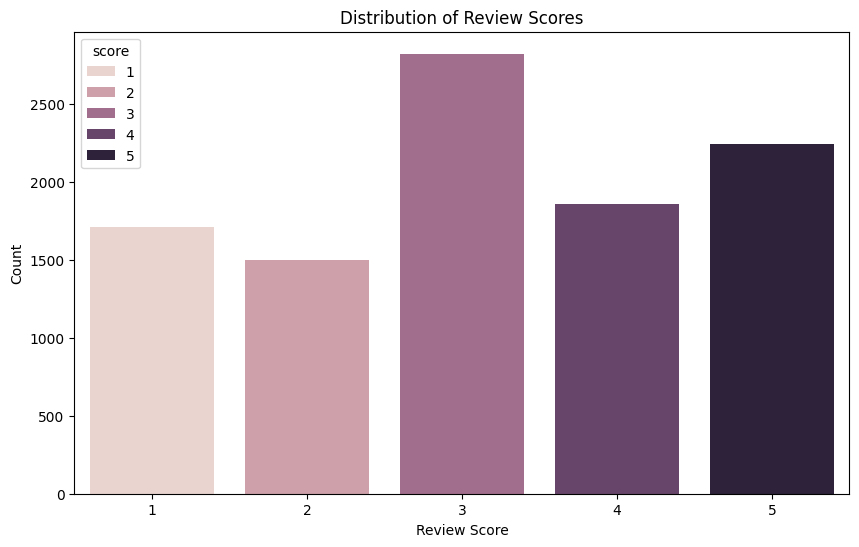

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.score, hue=df.score)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

## Limpieza y preparación de datos

Existe un desbalanceo en la variable objetivo, habiendo más críticas en la categoría 3 que en las demás. Para balancear el dataset, la mejor alternativa es dividir las categorías en 3 grupos, de manera que cada grupo tenga una cantidad similar de críticas.

In [8]:
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

In [9]:
print(f'Cantidad de críticas por categoría: {df.sentiment.value_counts()}')

Cantidad de críticas por categoría: sentiment
2    4101
0    3209
1    2820
Name: count, dtype: int64


Reduciendo el dataset a 3 categorías, se obtiene un poco más balanceado.

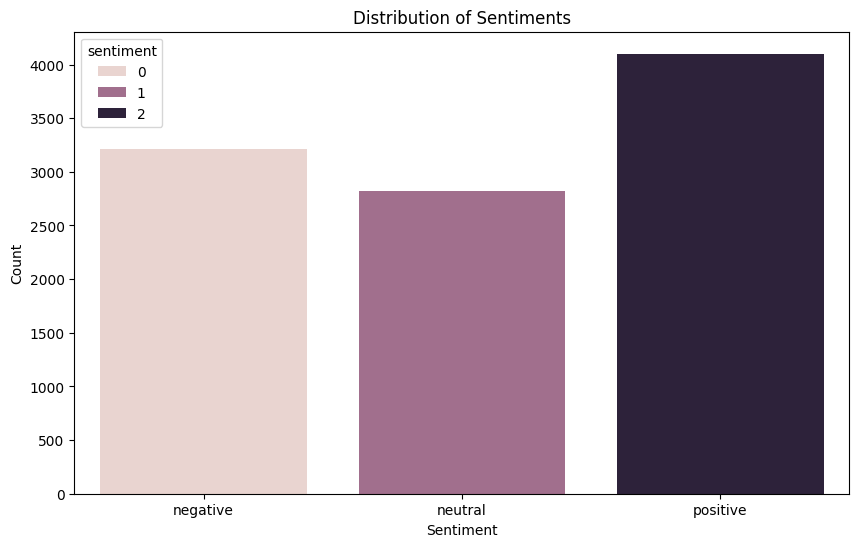

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.sentiment, hue=df.sentiment)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.show()

Como todavía existe un desbalanceo, se aplicará downsampling a las categorías positivo y negativo para que tengan la misma cantidad de críticas que la categoría neutral. De esa manera, se obtiene un dataset balanceado.

Cantidad de críticas por categoría después del submuestreo: sentiment
2    2820
0    2820
1    2820
Name: count, dtype: int64


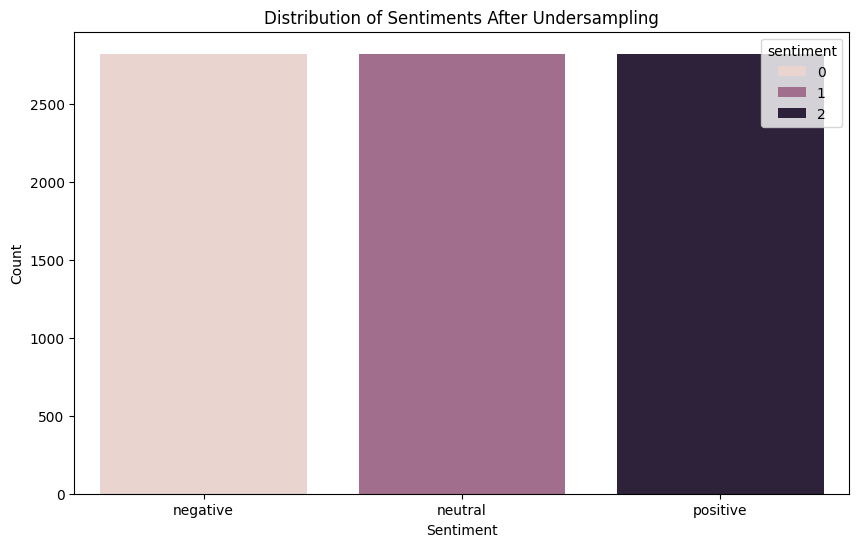

In [11]:
df_positive = df[df.sentiment == 2]
df_negative = df[df.sentiment == 0]
df_neutral = df[df.sentiment == 1]

# Downsampling the majority classes
df_positive_downsampled = resample(
                            df_positive, 
                            replace=False, 
                            n_samples=len(df_neutral),
                            random_state=42
                        )

df_negative_downsampled = resample(
                            df_negative, 
                            replace=False,
                            n_samples=len(df_neutral),
                            random_state=42
                        )

# Concatenating the downsampled majority classes with the minority class
df_balanced = pd.concat([df_positive_downsampled, df_negative_downsampled, df_neutral])
print(f'Cantidad de críticas por categoría después del submuestreo: {df_balanced.sentiment.value_counts()}')

plt.figure(figsize=(10, 6))
sns.countplot(x=df_balanced.sentiment, hue=df_balanced.sentiment)
plt.title('Distribution of Sentiments After Undersampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.show()

In [12]:
sentences = df_balanced['content'].values
print("Sentences shape:", sentences.shape)

# Display the first three sentences
for i, sentence in enumerate(sentences[:3], 1):
    print(f"Sentence {i}: {sentence}")

Sentences shape: (8460,)
Sentence 1: Good app it helps me be motivated without hesitation nor procastination. Thank you HabitNow!!!! Your love, Aliff
Sentence 2: Easy to use for a big family
Sentence 3: Great for general use and getting better.


A modo de explorar los datos, también se mostrará una gráfica de barras con la longitud de las críticas.

Average sentence length: 182.84905437352245
Max sentence length: 2176
Min sentence length: 1
Median sentence length: 141.0


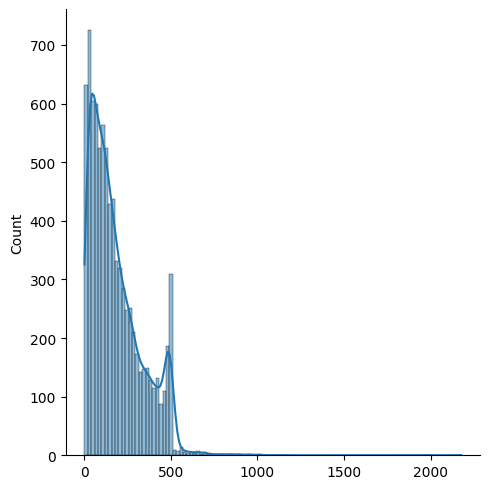

In [13]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Average sentence length:", np.mean(sentence_lens))
print("Max sentence length:", np.max(sentence_lens))
print("Min sentence length:", np.min(sentence_lens))
print("Median sentence length:", np.median(sentence_lens))

sns.displot(sentence_lens, kde=True)

Es necesario convertir la variables objetivo a variables categóricas.

In [14]:
# Extract the 'sentiment' column from the DataFrame
y = df_balanced['sentiment'].values
print(f"y shape: {y.shape}")

# Convert the sentiment labels to one-hot encoded format
y = tf.keras.utils.to_categorical(y, num_classes=3)
print(y[:3])

# Determine the output shape, which is the number of unique sentiment classes
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (8460,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
output shape: 3


## Definición del dataset

Se utilizará `BertTokenizer` para tokenizar las críticas en la preparación del dataset.

In [15]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Se dividirá el dataset en conjuntos de entrenamiento, validación y test.

In [16]:
indices = np.arange(len(sentences))

idx_train_val, idx_test = train_test_split(indices, test_size=0.15, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.30, random_state=42)

In [17]:
print(f"Training set size: {idx_train.shape[0]}")
print(f"Validation set size: {idx_val.shape[0]}")
print(f"Test set size: {idx_test.shape[0]}")

Training set size: 5033
Validation set size: 2158
Test set size: 1269


Se convierten los datos a InputExample y posteriormente TensorFlow Datasets.

In [89]:
batch_size = 128
max_length = 140

train_input_examples, validation_input_examples = convert_data_to_examples(sentences, y, idx_train, idx_val)
train_data = convert_examples_to_tf_dataset(list(train_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)

train_data = train_data.shuffle(100).batch(batch_size)

validation_data = convert_examples_to_tf_dataset(list(validation_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)
validation_data = validation_data.batch(batch_size)

Se tokeniza el texto y se convierte a `input_ids` y `attention_mask`.

In [90]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [91]:
X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_test = y[idx_test]

In [92]:
print(f"X_test[0] shape: {X_test[0].shape}")
print(f"y_test shape: {y_test.shape}")

X_test[0] shape: (1269, 140)
y_test shape: (1269, 3)


## Primer modelo: BERT pre-entrenado con pesos congelados

Se define el modelo BERT pre-entrenado.

In [93]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
def build_model_1(bert_model, max_length, output_shape, freeze_bert=True):
    """
    Build a model using the BERT model as the base
    """   
    # Set BERT model as not trainable
    bert_model.trainable = not freeze_bert

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Pass inputs to BERT model
    outputs = bert_model(input_ids, attention_mask=attention_mask)

    # Extract the pooled output
    pooled_output = outputs.pooler_output

    # Define the rest of the classification layers with batch normalization
    x = tf.keras.layers.Dense(512)(pooled_output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    output = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [95]:
model_1 = build_model_1(bert_model, max_length, output_shape)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01)

# Compile the model with F1 score
model_1.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.F1Score(average='macro')]
)

# Display model summary
model_1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_5 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

### Entrenamiento

In [96]:
history_1 = model_1.fit(
    train_data, 
    epochs=100, 
    validation_data=validation_data
)

Epoch 1/100
     40/Unknown - 22s 363ms/step - loss: 1.5116 - accuracy: 0.3447 - f1_score: 0.3398

2024-10-21 12:25:06.767573: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 12355278565906630782
2024-10-21 12:25:06.767625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 9447134531635676544
2024-10-21 12:25:06.767638: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7969666250672663954
2024-10-21 12:25:06.767641: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 1634815236662332951


40/40 [==============================] - 29s 557ms/step - loss: 1.5116 - accuracy: 0.3447 - f1_score: 0.3398 - val_loss: 1.3243 - val_accuracy: 0.3434 - val_f1_score: 0.2074
Epoch 2/100


2024-10-21 12:25:14.138225: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4763062740077271382
2024-10-21 12:25:14.138280: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 4666674938090049829
2024-10-21 12:25:14.138298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 7817856508107425195
2024-10-21 12:25:14.138322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8875583284082147109


40/40 [==============================] - 20s 504ms/step - loss: 1.4784 - accuracy: 0.3539 - f1_score: 0.3505 - val_loss: 1.3167 - val_accuracy: 0.3767 - val_f1_score: 0.3117
Epoch 3/100
40/40 [==============================] - 20s 505ms/step - loss: 1.4730 - accuracy: 0.3543 - f1_score: 0.3498 - val_loss: 1.3186 - val_accuracy: 0.3753 - val_f1_score: 0.3236
Epoch 4/100
40/40 [==============================] - 20s 506ms/step - loss: 1.4544 - accuracy: 0.3626 - f1_score: 0.3576 - val_loss: 1.3230 - val_accuracy: 0.3721 - val_f1_score: 0.3179
Epoch 5/100
40/40 [==============================] - 20s 505ms/step - loss: 1.4368 - accuracy: 0.3739 - f1_score: 0.3698 - val_loss: 1.3224 - val_accuracy: 0.3693 - val_f1_score: 0.3242
Epoch 6/100
40/40 [==============================] - 20s 506ms/step - loss: 1.4360 - accuracy: 0.3702 - f1_score: 0.3679 - val_loss: 1.3185 - val_accuracy: 0.3851 - val_f1_score: 0.3574
Epoch 7/100
40/40 [==============================] - 20s 506ms/step - loss: 1.4171

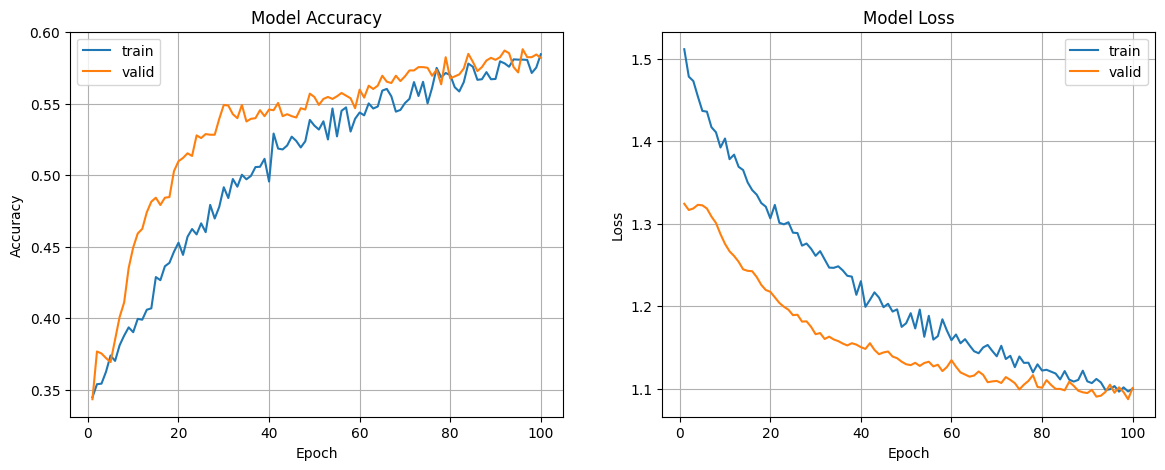

In [97]:
plot_train_metrics(history_1)

Se puede ver que el modelo converge al mismo ritmo en el dataset de validación y de entrenamiento durante varias épocas. Sin embargo, llegando a la época 100, el desempeño en los datasets de entrenamiento y validación comienzan a converger, por lo que seguir entrenando el modelo no sería beneficioso y podría llevar a overfitting.	Bajo estas condiciones, se detiene el entrenamiento con un accuracy de 0.58 en el dataset de entrenamiento y validación.

A continuación se verificará si el desempeño se mantiene con el conjunto de test.

In [98]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

40/40 [==============================] - 5s 81ms/step


array([[0.4035884 , 0.41482186, 0.18158977],
       [0.31719202, 0.60806394, 0.07474401],
       [0.03433369, 0.10835458, 0.85731167]], dtype=float32)

In [99]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [100]:
scores = model_1.evaluate(X_test, y_test)

print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")
print(f"Test F1 Score: {scores[2]}")

40/40 [==============================] - 5s 83ms/step - loss: 1.0831 - accuracy: 0.5816 - f1_score: 0.5749
Test loss: 1.0830878019332886
Test accuracy: 0.5815602540969849
Test F1 Score: 0.5748715996742249


Las métricas obtenidas para el conjunto de test son consistentes con las obtenidas en el conjunto de validación.

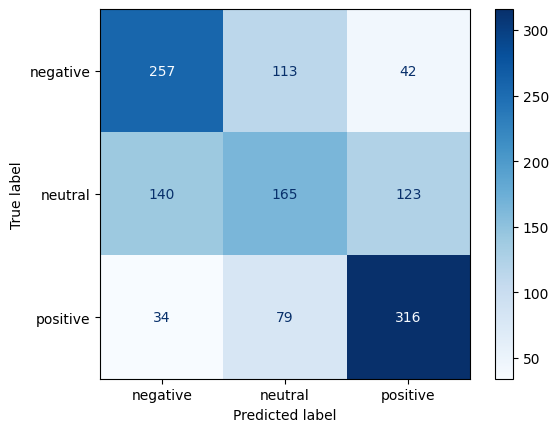

In [101]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

La matriz de confusión muestra que el modelo clasifica correctamente una cantidad significativa de instancias negativas y positivas, pero tiene dificultades con la clase neutral, ya que una gran parte de estas se clasifican incorrectamente como negativas o positivas.

In [102]:
model_1.save_weights('bert_model_1_weights.h5')

In [103]:
# Load the bert model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
# Build the model
model_1_loaded = build_model_1(bert_model, max_length, output_shape)
# Load the weights
model_1_loaded.load_weights('bert_model_1_weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [104]:
text = "I love this app!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [106]:
y_prob_ensayo = model_1_loaded.predict(X_test)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 1s 1s/step
Clasificación: positive


In [107]:
text = "I hate this product, it is terrible!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_1_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 110ms/step
Clasificación: negative


In [108]:
text = "The app is okay, nothing special. It works as expected but doesn't stand out in any way."

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_1_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 110ms/step
Clasificación: neutral


Pese a que las métricas alcanzadas no son las mejores. Como se puede ver en las pruebas realizadas, el modelo con los pesos cargados realiza clasificaciones correctas.

## Segundo modelo: BERT Fine tuning

Para evitar problemas con la memoria de la GPU, se utilizará un tamaño de batch más pequeño para el fine tuning, también una longitud máxima de 120 por el mismo motivo.

In [26]:
batch_size = 16
max_length = 120

train_input_examples, validation_input_examples = convert_data_to_examples(sentences, y, idx_train, idx_val)
train_data = convert_examples_to_tf_dataset(list(train_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)

train_data = train_data.shuffle(100).batch(batch_size)

validation_data = convert_examples_to_tf_dataset(list(validation_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)
validation_data = validation_data.batch(batch_size)

El resto del procesamiento es similar al anterior.

In [27]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [28]:
X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_test = y[idx_test]

In [29]:
print(f"X_test[0] shape: {X_test[0].shape}")
print(f"y_test shape: {y_test.shape}")

X_test[0] shape: (1269, 120)
y_test shape: (1269, 3)


Definiendo el modelo BERT pre-entrenado con pesos no congelados para realizar fine tuning. 

In [30]:
def build_model_2(bert_model, max_length, output_shape, freeze_bert=False):
    """
    Build a model using the BERT model as the base
    """   
    # Set BERT model trainable or not
    bert_model.trainable = not freeze_bert

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Pass inputs to BERT model
    outputs = bert_model(input_ids, attention_mask=attention_mask)

    # Extract the pooled output
    pooled_output = outputs.pooler_output

    # Define the rest of the classification layers with batch normalization
    x = tf.keras.layers.Dropout(0.5)(pooled_output)
    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001), bias_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    output = tf.keras.layers.Dense(
        output_shape, 
        activation='softmax', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001), 
        bias_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [35]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Build the model without freezing the BERT model
model_2 = build_model_2(bert_model, max_length, output_shape, freeze_bert=False)

for layer in model_2.layers:
  layer.trainable = True

# Define the optimizer with weight decay 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.001)

# Compile the model
model_2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 120)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 120)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_3 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 120, 7                                     

In [36]:
history_2 = model_2.fit(
    train_data, 
    epochs=5,
    validation_data=validation_data,
)

Epoch 1/5
    315/Unknown - 57s 121ms/step - loss: 1.1456 - accuracy: 0.4321

2024-10-21 14:02:40.885887: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 691377383324475622
2024-10-21 14:02:40.885929: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6176623019721198426
2024-10-21 14:02:40.885933: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5384226914516588739
2024-10-21 14:02:40.885935: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 8822516212797148809


315/315 [==============================] - 65s 146ms/step - loss: 1.1456 - accuracy: 0.4321 - val_loss: 0.8810 - val_accuracy: 0.6019
Epoch 2/5


2024-10-21 14:02:48.621922: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 12959133589009129970
2024-10-21 14:02:48.621965: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 9757000399338805946
2024-10-21 14:02:48.621968: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 10453760213437762518
2024-10-21 14:02:48.621971: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2001887982410883101


315/315 [==============================] - 42s 134ms/step - loss: 0.9116 - accuracy: 0.5931 - val_loss: 0.8242 - val_accuracy: 0.6529
Epoch 3/5
315/315 [==============================] - 41s 131ms/step - loss: 0.7980 - accuracy: 0.6807 - val_loss: 0.8518 - val_accuracy: 0.6409
Epoch 4/5
315/315 [==============================] - 41s 130ms/step - loss: 0.7175 - accuracy: 0.7171 - val_loss: 0.8143 - val_accuracy: 0.6617
Epoch 5/5
315/315 [==============================] - 41s 129ms/step - loss: 0.6199 - accuracy: 0.7806 - val_loss: 0.8508 - val_accuracy: 0.6538


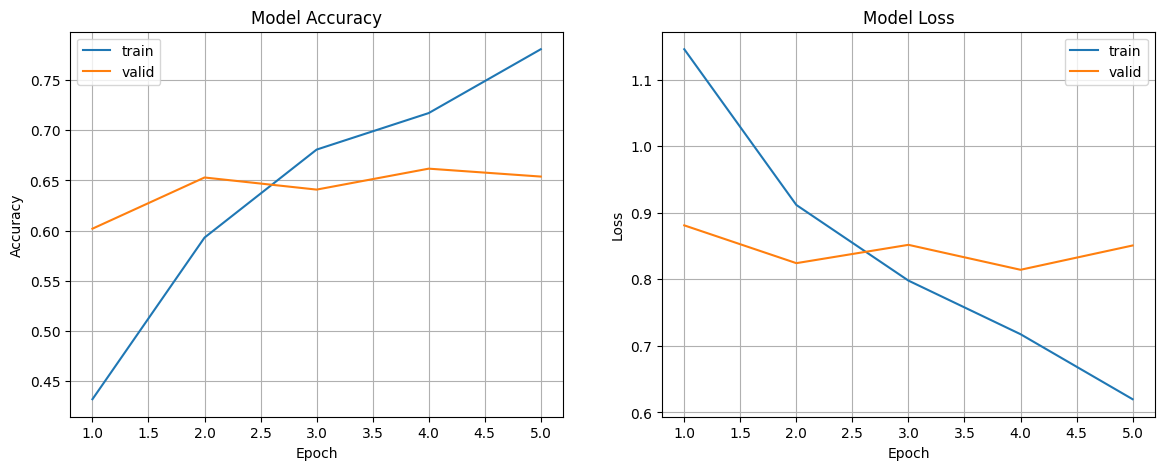

In [37]:
plot_train_metrics(history_2)

Se puede ver que el modelo no logra mucha mejoría en el dataset de validación, pese a las técnicas de regularización aplicadas. Se detiene el entrenamiento con un accuracy de 0.78 en el dataset de entrenamiento y 0.65 en el dataset de validación.

A continuación se verificará si el desempeño se mantiene con el conjunto de test.

In [38]:
y_hat_prob = model_2.predict(X_test)
y_hat_prob[:3]

40/40 [==============================] - 4s 67ms/step


array([[0.32177332, 0.6334905 , 0.0447362 ],
       [0.12842213, 0.6148292 , 0.25674874],
       [0.00351803, 0.01001068, 0.98647124]], dtype=float32)

In [39]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [40]:
scores = model_2.evaluate(X_test, y_test)

print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")

40/40 [==============================] - 4s 70ms/step - loss: 0.8309 - accuracy: 0.6864
Test loss: 0.8308578729629517
Test accuracy: 0.6863672137260437


Las métricas obtenidas para el conjunto de test son consistentes con las obtenidas en el conjunto de validación. Nótense que existe una leve mejora respecto al primer modelo.

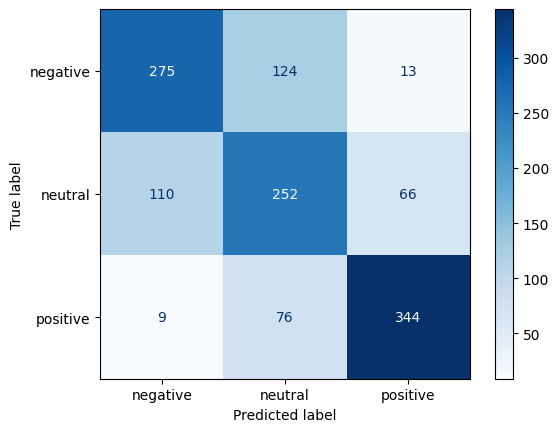

In [41]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

La matriz de confusión muestra que el modelo ha mejorado en la clasificación de la clase neutral, pero ha empeorado en la clasificación de las clases negativas y positivas.

In [42]:
model_2.save_weights('bert_model_2_weights.h5')

In [43]:
# Load the bert model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
# Build the model
model_2_loaded = build_model_2(bert_model, max_length, output_shape, freeze_bert=False)
# Load the weights
model_2_loaded.load_weights('bert_model_2_weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
text = "I love this app!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0]], shape=(1, 120), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [45]:
y_prob_ensayo = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 1s 1s/step
Clasificación: positive


In [46]:
text = "I hate this product, it is terrible!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 109ms/step
Clasificación: negative


In [47]:
text = "The app is okay, nothing special."

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 100ms/step
Clasificación: neutral


Se puede ver que el modelo con fine tuning también logra clasificaciones correctas, aunque sin lograr mejorar significativamente el desempeño del modelo con los pesos congelados. Sin embargo, debido a que se necesito mucho menos tiempo para entrenar el modelo con fine tuning, se podría considerar que es una mejor opción.